Saved: outputs\Figure_3_1_2a_far_light_three_sensors.(png|svg) ,  outputs\Figure_3_1_2b_21n18_far_vs_close.(png|svg) , and  outputs\Figure_3_1_2_data.csv


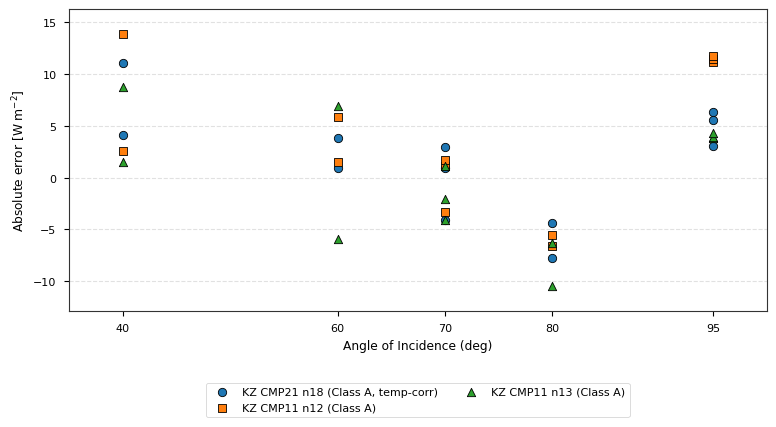

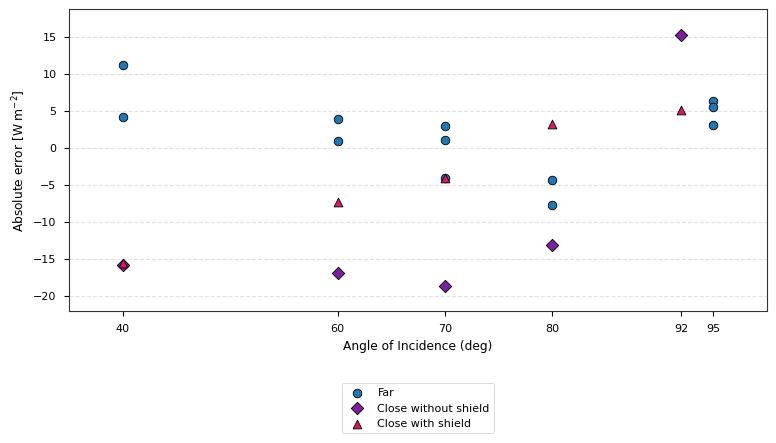

In [ ]:
import os

# ------------------------------------------------------------
# Output
# ------------------------------------------------------------

BASE_DIR= r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
OUT_DIR = os.path.join(BASE_DIR,"v_results_3_output")

# -*- coding: utf-8 -*-
# Figure 3.1.2 — (a) Far light source: 3 sensors vs AOI; (b) Sensor 21n18: far vs close (with/without shield)
# Updates (Prompt instruction 3 - advanced):
#   • Scatter points only (no connecting lines)
#   • Side labels (one decimal) with:
#       - left/right alternation per AOI to reduce collisions
#       - within-series duplicates at the same AOI: label only the point with highest |value|(15/10/25: to be tested highest/lowest ? )
#       - keep labels inside axes (auto-flip + clamping)
#   • AOI domain widened to [35°, 100°] to keep symbols and labels inside
#   • SHOW_VALUES boolean to toggle label visibility (15/10/25: set false since )

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ------------------------------ CONFIG ------------------------------
SHOW_VALUES = False          # <-- set to False to hide all numeric labels (requirement b)
FIGSIZE = (9.0, 5.2)
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Axis domain
XMIN, XMAX = 35, 100        # widen x-axis to keep markers/labels inside

# ------------------------------ STYLE ------------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": 10,
})
# thesis style file:
# import matplotlib as mpl
# mpl.style.use(['seaborn-paper', 'thesis'])

# ============================== DATA ===============================
# (a) FAR light source, three sensors (AOI sequence as in your previous file)
AOI_far = [0, 40, 60, 70, 0, 70, 80, 0, 40, 60, 70, 80, 95, 95, 95]
far_data = {
    # "Class A pyr. 18 (far)": [
    "Class A pyr. 18 (far)": [
        -5.775079015582843E-3, 11.107417502643973, 3.8412063016212246, 0.9803222608288859,
        -1.2819834136064859E-2, 2.938960789706236, -4.4049344908641475,
        -2.7588110864461808E-3, 4.1456531810148824, 0.9450669292211271, -4.049594119139651,
        -7.783869723469705, 3.1032727893296785, 6.300960833230213, 5.542534460870411
    ],
    "Class A type 1 pyr. 12 (far)": [
        -2.3020195644746504E-3, 13.858449444152098, 5.884448831975466, 1.1343095797629927,
        -4.852771341894474E-3, 1.752964809825715, -6.631682370086436,
        -1.619552375680028E-3, 2.568914428847004, 1.4905675095061954, -3.3295930214926717,
        -5.571707514860408, 11.173925668106463, 11.452533673684311, 11.760227725320549
    ],
    "Class A type 1 pyr. 13 (far)": [
        -4.293579462990601E-3, 1.5146692221246734, -5.935822353366439, -4.111667161955305,
        -9.321806195162874E-3, -2.0302561856530126, -10.415205073376253,
        -3.596839093642171E-3, 8.787864645367662, 6.92504248864418, 1.1632683160956874,
        -6.264805495373548, 3.8625871043166486, 3.960197415833524, 4.345696344791002
    ],
}

# (b) 21n18: far vs close (with / without shield)
AOI_far_18 = AOI_far
Y_far_18   = far_data["Class A pyr. 18 (far)"]

# Close (without shield). Input had NaN at 0°
AOI_close_wo = [0, 40, 60, 70, 80, 92]
Y_close_wo   = [np.nan, -15.819194072588443, -16.898096835585967,
                -18.668233798398536, -13.185171084622437, 15.262747387031281]

# Close (with shield)
AOI_close_w = [40, 60, 70, 80, 92]
Y_close_w   = [-15.584263230152485, -7.346302484280673, -4.1399880002465812,
               3.2145565507412912, 5.0726492433044141]

# ============================== HELPERS ===============================
def filter_range(xs, ys, xmin=XMIN, xmax=XMAX):
    """Filter paired arrays to xmin ≤ x ≤ xmax and finite values."""
    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)
    m = np.isfinite(xs) & np.isfinite(ys) & (xs >= xmin) & (xs <= xmax)
    return xs[m], ys[m]

def label_mask_highest_abs_at_same_x(xs, ys):
    """
    For duplicate x values *within one series*, keep label only for the point
    with the highest absolute y. Return boolean mask with True where we should place a label.
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    mask = np.zeros_like(xs, dtype=bool)
    # group indices by exact AOI value
    unique_x = np.unique(xs)
    for xv in unique_x:
        idx = np.where(xs == xv)[0]
        if len(idx) == 1:
            mask[idx[0]] = True
        else:
            # choose index with max |y|
            k = idx[np.argmax(np.abs(ys[idx]))]
            mask[k] = True
    return mask

def annotate_side_labels(ax, xs, ys, series_rank, n_series,
                         fmt="{:.1f}", fs=8.2, dx=1.0, dy_step=0.25,
                         alternate_by_x=True, x_margin_deg=1.2):
    """
    Place one-decimal labels to the side of each point, keeping them inside the axes.
    - default orientation: alternate left/right by AOI (if alternate_by_x=True)
    - if label would go out of right edge, flip to the left (and vice versa)
    - small vertical stagger based on series_rank to reduce overlap
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    x_left, x_right = ax.get_xlim()
    y_bottom, y_top = ax.get_ylim()
    y_margin = 0.02 * (y_top - y_bottom)

    # vertical stagger around point, per series order
    rank_centered = series_rank - (n_series - 1) / 2.0
    dy = rank_centered * dy_step

    # build alternation map per AOI to spread labels left/right
    alt_map = {}
    for xv, yv in zip(xs, ys):
        if not np.isfinite(yv):
            continue
        # Decide initial orientation
        if alternate_by_x:
            # Toggle per AOI: first occurrence → 'right', second → 'left', etc.
            if xv not in alt_map:
                alt_map[xv] = 0
            alt = alt_map[xv] % 2  # 0=right, 1=left
            alt_map[xv] += 1
            go_right = (alt == 0)
        else:
            go_right = True

        # Base x for label
        x_txt = xv + dx if go_right else xv - dx
        ha = "left" if go_right else "right"

        # Keep inside: if too near an edge, flip/clamp
        if go_right and x_txt > (x_right - x_margin_deg):
            # Flip to left
            x_txt = xv - dx
            ha = "right"
        if (not go_right) and x_txt < (x_left + x_margin_deg*0.8):
            # Flip to right
            x_txt = xv + dx
            ha = "left"

        # Vertical clamp
        y_txt = yv + dy
        y_txt = min(max(y_txt, y_bottom + y_margin), y_top - y_margin)

        ax.text(x_txt, y_txt, fmt.format(yv),
                ha=ha, va="center", fontsize=fs,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=0.6),
                zorder=5, clip_on=False)

def compute_ylim_with_pad(*arrays, pad_frac=0.10):
    """Return (ymin, ymax) covering the given arrays with symmetric padding."""
    vals = []
    for a in arrays:
        a = np.asarray(a, dtype=float)
        if a.size:
            vals.append(a)
    if not vals:
        return -1, 1
    y = np.concatenate(vals)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return -1, 1
    ymin, ymax = float(np.nanmin(y)), float(np.nanmax(y))
    span = (ymax - ymin) if ymax > ymin else 1.0
    pad = pad_frac * span
    return ymin - pad, ymax + pad

# ============================== EXPORT (optional) ===============================
# Wide CSV for traceability (unfiltered)
df_far = pd.DataFrame({"aoi_deg": AOI_far})
for lbl, vals in far_data.items():
    df_far[lbl] = vals
df_close = pd.DataFrame({"aoi_deg_far": AOI_far_18, "21n18_far": Y_far_18})
df_close_wo = pd.DataFrame({"aoi_deg_close_wo": AOI_close_wo, "21n18_close_wo_shield": Y_close_wo})
df_close_w  = pd.DataFrame({"aoi_deg_close_w": AOI_close_w, "21n18_close_w_shield": Y_close_w})

pd.concat(
    {"far_three_sensors": df_far,
     "21n18_far": df_close,
     "21n18_close_wo": df_close_wo,
     "21n18_close_w": df_close_w},
    axis=1
).to_csv(os.path.join(OUT_DIR, "Figure_3_1_2_data.csv"), index=False)

# ============================== (a) PLOT — FAR (THREE SENSORS) ===============================
# Filter to x-domain [35, 100]
AOI_far_f = {}
Y_far_f   = {}
for key, yvals in far_data.items():
    xf, yf = filter_range(AOI_far, yvals, XMIN, XMAX)
    AOI_far_f[key] = xf
    Y_far_f[key]   = yf

fig, ax = plt.subplots(figsize=FIGSIZE)

# Distinct colors/markers (as before)
far_styles = [
    dict(color="#1f77b4", marker="o",  size=36, label="KZ CMP21 n18 (Class A, temp-corr)"), #Class A pyr. 18 (far)"),      # blue
    dict(color="#ff7f0e", marker="s",  size=36, label="KZ CMP11 n12 (Class A)"),#Class A type 1 pyr. 12 (far)"),# orange
    dict(color="#2ca02c", marker="^",  size=36, label="KZ CMP11 n13 (Class A)"),#Class A type 1 pyr. 13 (far)"),# green
]
far_keys = list(far_data.keys())
n_far = len(far_keys)

# Pre-set axes to the requested x-domain and padded y-domain
all_y_far = np.concatenate([Y_far_f[k] for k in far_keys if len(Y_far_f[k]) > 0]) if any(len(Y_far_f[k])>0 for k in far_keys) else np.array([0.0])
ymin_a, ymax_a = compute_ylim_with_pad(all_y_far, pad_frac=0.10)
ax.set_xlim(XMIN, XMAX)
ax.set_ylim(ymin_a, ymax_a)

for i, key in enumerate(far_keys):
    st = far_styles[i % len(far_styles)]
    xs = AOI_far_f[key]; ys = Y_far_f[key]
    # SCATTER ONLY
    ax.scatter(xs, ys, s=st["size"], c=st["color"],
               marker=st["marker"], edgecolors="black", linewidths=0.6,
               zorder=3, label=st["label"])

    # Labels with de-duplication (same series, same AOI) and alternation per AOI
    if SHOW_VALUES and xs.size:
        mask = label_mask_highest_abs_at_same_x(xs, ys)  # label only highest |y| at duplicate AOI for this series
        annotate_side_labels(ax, xs[mask], ys[mask],
                             series_rank=i, n_series=n_far,
                             fmt="{:.1f}", fs=8.0, dx=1.0, dy_step=0.25,
                             alternate_by_x=True, x_margin_deg=1.2)

# Axes/labels (no title)
ax.set_xlabel("Angle of Incidence (deg)")
ax.set_ylabel("Absolute error [W m$^{-2}$]")
ax.grid(True, axis="y"); ax.grid(False, axis="x")

# X ticks present in filtered data within the domain
xticks_a = sorted(set(np.concatenate([AOI_far_f[k] for k in far_keys if AOI_far_f[k].size > 0]))) if any(AOI_far_f[k].size>0 for k in far_keys) else [40, 60, 70, 80, 95]
ax.set_xticks(xticks_a)

# Legend below
leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2, frameon=True)
leg.get_frame().set_linewidth(0.6)
fig.subplots_adjust(bottom=0.30)

fig.savefig(os.path.join(OUT_DIR, "Figure_3_1_2a_far_light_three_sensors.png"), dpi=300)
fig.savefig(os.path.join(OUT_DIR, "Figure_3_1_2a_far_light_three_sensors.svg"))

# ============================== (b) PLOT — 21n18: FAR vs CLOSE ===============================
# Filter to domain [35, 100]
x_far18, y_far18 = filter_range(AOI_far_18, Y_far_18, XMIN, XMAX)
x_cwo,   y_cwo   = filter_range(AOI_close_wo, Y_close_wo, XMIN, XMAX)
x_cw,    y_cw    = filter_range(AOI_close_w,  Y_close_w,  XMIN, XMAX)

fig2, ax2 = plt.subplots(figsize=FIGSIZE)

# Colors to avoid confusion with far 12/13 (orange/green retained in panel a)
st_far18 = dict(color="#1f77b4", marker="o", size=38, label="Far") #Class A pyr. 18 — far")                   # blue
st_cwo   = dict(color="#7b1fa2", marker="D", size=40, label="Close without shield") # without Class A pyr. 18 — close (without shield)")# purple
st_cw    = dict(color="#d81b60", marker="^", size=40, label="Close with shield") #Class A pyr. 18 — close (with shield)")   # rose

# Pre-set axes limits before placing labels
ymin_b, ymax_b = compute_ylim_with_pad(y_far18, y_cwo, y_cw, pad_frac=0.10)
ax2.set_xlim(XMIN, XMAX)
ax2.set_ylim(ymin_b, ymax_b)

# Scatter
ax2.scatter(x_far18, y_far18, s=st_far18["size"], c=st_far18["color"],
            marker=st_far18["marker"], edgecolors="black", linewidths=0.6,
            zorder=3, label=st_far18["label"])
ax2.scatter(x_cwo, y_cwo, s=st_cwo["size"], c=st_cwo["color"],
            marker=st_cwo["marker"], edgecolors="black", linewidths=0.6,
            zorder=3, label=st_cwo["label"])
ax2.scatter(x_cw, y_cw, s=st_cw["size"], c=st_cw["color"],
            marker=st_cw["marker"], edgecolors="black", linewidths=0.6,
            zorder=3, label=st_cw["label"])

# Labels with de-duplication in case of duplicates at same AOI within a series
if SHOW_VALUES:
    if x_far18.size:
        mask18 = label_mask_highest_abs_at_same_x(x_far18, y_far18)
        annotate_side_labels(ax2, x_far18[mask18], y_far18[mask18],
                             series_rank=0, n_series=3,
                             fmt="{:.1f}", fs=8.0, dx=1.0, dy_step=0.25,
                             alternate_by_x=True, x_margin_deg=1.2)
    if x_cwo.size:
        maskwo = label_mask_highest_abs_at_same_x(x_cwo, y_cwo)
        annotate_side_labels(ax2, x_cwo[maskwo], y_cwo[maskwo],
                             series_rank=1, n_series=3,
                             fmt="{:.1f}", fs=8.0, dx=1.0, dy_step=0.25,
                             alternate_by_x=True, x_margin_deg=1.2)
    if x_cw.size:
        maskw = label_mask_highest_abs_at_same_x(x_cw, y_cw)
        annotate_side_labels(ax2, x_cw[maskw], y_cw[maskw],
                             series_rank=2, n_series=3,
                             fmt="{:.1f}", fs=8.0, dx=1.0, dy_step=0.25,
                             alternate_by_x=True, x_margin_deg=1.2)

# Axes/labels
ax2.set_xlabel("Angle of Incidence (deg)")
ax2.set_ylabel("Absolute error [W m$^{-2}$]")
ax2.grid(True, axis="y"); ax2.grid(False, axis="x")

# X ticks present in filtered data within the domain
xticks_b = sorted(set(np.concatenate([v for v in [x_far18, x_cwo, x_cw] if v.size > 0]))) if any(v.size>0 for v in [x_far18, x_cwo, x_cw]) else [40, 60, 70, 80, 95]
ax2.set_xticks(xticks_b)

# Legend below
leg2 = ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=1, frameon=True)
leg2.get_frame().set_linewidth(0.6)
fig2.subplots_adjust(bottom=0.30)

fig2.savefig(os.path.join(OUT_DIR, "Figure_3_1_2b_21n18_far_vs_close.png"), dpi=300)
fig2.savefig(os.path.join(OUT_DIR, "Figure_3_1_2b_21n18_far_vs_close.svg"))

print(
    "Saved:",
    os.path.join(OUT_DIR, "Figure_3_1_2a_far_light_three_sensors.(png|svg)"), ", ",
    os.path.join(OUT_DIR, "Figure_3_1_2b_21n18_far_vs_close.(png|svg)"), ", and ",
    os.path.join(OUT_DIR, "Figure_3_1_2_data.csv")
)